In [1]:
import numpy as np
import random as rnd
import eq_functions as eq
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1756)
rnd.seed(1756)

# define parameters
Nt = 400
Tf = 32 # unit time
a = np.log10(Nt)
b = 1.
c = 1.
cprime = 1.
p = 1.1
pprime = 1.8
Mc = 3.

In [2]:
# Making the catalog

times = np.linspace(0,Tf,3*Tf+1) # time intervals
dt = times[1]-times[0]# define time increment

# intended column order
cols = ['n_avg','Events','Magnitude','Distance','theta','Time']
events_occured = 0 # number of earthquakes generated 
for t in times[:-1]: # for each time interval
    # average seismicity rate on interval [t,t+dt]
    n_avg = eq.average_seismicity(t,t+dt,Tf,a,p,c)
    
    # generate number of events according to a Poisson process
    X = int((eq.sample_poisson(n_avg,1)))
    
    # assign each event a magnitude according to GR
    mgtds = eq.sample_magnitudes(X, Mc, b)
    
    distances = eq.sample_location(X, cprime, pprime)
    thetas = np.random.uniform(0, 2*np.pi, X)
    
    # generate the times at which each event occurs, according to an exponential distribution.
    # the parameter for the exponential distribution at time interval [t,t+dt] is the expected number
    # of events on this interval according to the Omori law
    times = np.zeros(X)
    inter_times = eq.sample_intereventtimes(n_avg/dt, X)
    for i in range(X):
        if i == 0:
            times[i] = t
        else:
            times[i] = inter_times[i] + times[i-1]

    
    # store results in dataframe
    if t == 0: # initial dataframe, full dataframe constructed via concatenation in subsequent iterations
        # index label for current time interval
        if X != 0:
            interval = [''] * X
            interval[0] = ['Interval: [{:.2f},{:.2f}]'.format(t,t+dt)] # only include interval label on first row
            # create dataframe using dict of objects
            Xcol = ['']*X # only include number of events on first row
            Xcol[0] = X
            n_avgcol = ['']*X
            n_avgcol[0] = n_avg # only include average number of events on first row
            catalog = pd.DataFrame({'Magnitude': mgtds,
                                   'Events':Xcol,
                                   'n_avg':n_avgcol,
                                   'Distance':distances,
                                   'Time':times,
                                   'theta':thetas}, index = interval)
            catalog = catalog.reindex(columns = cols)
        else: # formatting for when there are no events during a time interval
            interval = ['Interval: [{:.2f},{:.2f}]'.format(t,t+dt)]
            catalog = pd.DataFrame({'M': ['-'],
                                      'X':[X],
                                      'n_avg':[n_avg],
                                      'Distance':['-'],
                                      'Time':['-'],
                                      'theta':['-']}, index = interval)
            catalog = catalog.reindex(columns = cols)
    else: # join new results to existing catalog
        # index label for current time interval
        if X != 0: 
            interval = [''] * X
            interval[0] = ['Interval: [{:.2f},{:.2f}]'.format(t,t+dt)]# * X
            Xcol = ['']*X
            Xcol[0] = X
            n_avgcol = ['']*X
            n_avgcol[0] = n_avg
            catalog_update = pd.DataFrame({'Magnitude': mgtds,
                                      'Events':Xcol,
                                      'n_avg':n_avgcol,
                                      'Distance':distances,
                                      'Time':times,
                                      'theta':thetas}, index = interval)
            catalog_update = catalog_update.reindex(columns = cols)
        else: # formatting for when there are no events during a time interval
            interval = ['Interval: [{:.2f},{:.2f}]'.format(t,t+dt)]
            catalog_update = pd.DataFrame({'Magnitude': ['-'],
                                      'Events':[X],
                                      'n_avg':[n_avg],
                                      'Distance':['-'],
                                      'Time':['-'],
                                      'theta':['-']}, index = interval)
            catalog_update = catalog_update.reindex(columns = cols)
        frames = [catalog, catalog_update]
        catalog = pd.concat(frames)

    events_occured += X # just to keep track, since nrows catalog is not necessarily equal to this

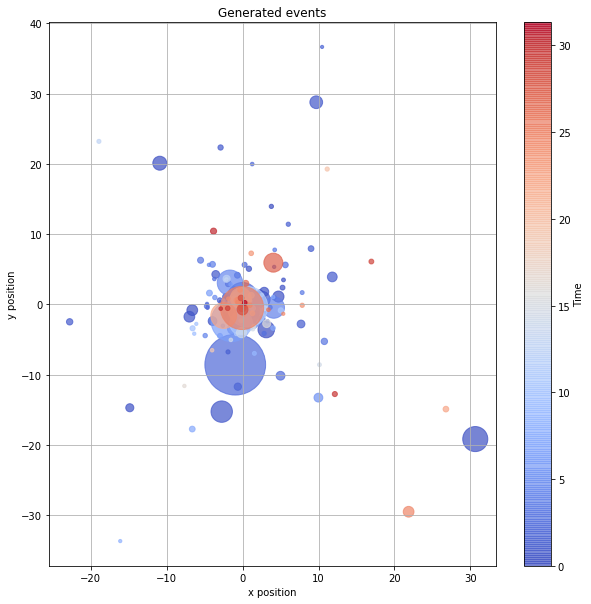

In [4]:
# Plotting the catalog

fig= plt.figure()
ax = fig.add_subplot(111)#, projection = 'polar')
fig.set_figheight(10)
fig.set_figwidth(10)

theta = catalog['theta']
try:    
    theta = theta.loc[theta != '-'] # when there are no intervals containing no events (marked by '-'), this comparison doesnt work. will look into better way of getting around it
except TypeError:
    pass
theta = np.array(theta, dtype = np.float) # needs to be float 

dist = catalog['Distance']
try:
    dist = dist.loc[dist != '-']
except TypeError:
    pass
dist = np.array(dist, dtype = np.float)
x = dist * np.cos(theta)
y = dist * np.sin(theta)


times = catalog['Time']
try:
    times = times.loc[times != '-']
except TypeError:
    pass
times = np.array(times, dtype = np.float)

magnitudes = catalog['Magnitude']
try:
    magnitudes = magnitudes.loc[magnitudes != '-']
except TypeError:
    pass
magnitudes = np.array(magnitudes, dtype = np.float)

plot = ax.scatter(x, y,
           c = times,
           s = 0.01*10**magnitudes, # large events much bigger than smaller ones
           cmap = 'coolwarm', alpha = 0.7)

cbar = fig.colorbar(plot)
cbar.set_label('Time')

plt.title('Generated events')
plt.ylabel('y position')
plt.xlabel('x position')
plt.grid(True)
plt.show()

#catalog.to_csv('catalog.csv')